# Point Process Analysis Aggregation
A theoretical framework for evaluating the performance of centroid and proportional allocation approaches.

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
N = 1000
# dg = np.linspace(0.01, 0.99, N)
# dg = np.logspace(-3, -0.01, N)
dg = np.logspace(-3, -0.01, N)
dp = 0.5*np.ones(N)
ratio = dp / dg
rate = 100
start = -1
end = 2


# Empirical evaluation of homogeneous and non-homogeneous point process
Empirically compare proportional allocation and centroid allocation approaches under three forms of point process:
1. Homogeneous Poisson point process
2. Non-homogeneous Neyman Scott process
3. Non-homogeneous Log-Gaussian Cox process

In [2]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.interpolate import CubicSpline

# Homogeneous Poisson Process
def get_poisson_process_samples(rate,start=0,end=1):
    """
    Generate sample data where the number of samples are Poisson distributed 
    and the values are uniformly distributed on [0,1].
    """
    delta = end - start
    s = np.random.poisson(rate*delta)
    return np.random.rand(s) * (end - start) + start

# Inhomogeneous Poisson Processes (next two functions)
def get_neyman_scott_process(lambda_p, lambda_c, sigma, start=0, end=1):
    """
    Simulate a Neyman-Scott process in 1D.
    
    Parameters:
    - lambda_p: Intensity of parent points (mean number of parents per unit length)
    - lambda_c: Mean number of offspring per parent
    - sigma: Standard deviation of the normal distribution for offspring displacement
    
    Returns:
    - Array of points sampled from the Neyman-Scott process
    """
    # 1. Generate parent points
    delta = end - start
    num_parents = max(np.random.poisson(lambda_p * delta),1)  # Ensure at least one parent
    parent_points = np.random.uniform(start, end, num_parents)

    offspring_points = []
    
    # 2. For each parent, generate offspring
    for parent in parent_points:
        num_offspring = np.random.poisson(lambda_c)
        displacements = np.random.normal(0, sigma, num_offspring)
        offspring = parent + displacements
        offspring_points.append(offspring)
    
    # Combine all points into a single array
    return np.concatenate((np.concatenate(offspring_points), parent_points))

def get_log_gaussian_cox_process(dx, mean_log_intensity, variance, length_scale, start=0, end=1):
    # Discretize space
    x = np.arange(start, end, dx)
    n = len(x)
    
    # Compute covariance matrix (Squared Exponential Kernel)
    dists = cdist(x[:, None], x[:, None], metric='euclidean')
    K = variance * np.exp(-0.5 * (dists / length_scale)**2)
    
    # Sample from multivariate normal (Gaussian Process)
    mean_vector = mean_log_intensity * np.ones(n)
    G = np.random.multivariate_normal(mean_vector, K)
    
    # Exponentiate to get positive intensities
    Lambda = np.exp(G)
    
    # Create a continuous intensity function using interpolation
    Lambda_hat = CubicSpline(x, Lambda)
    
    # plt.plot(x, Lambda, marker='.',linestyle=None, label='Intensity Function $\\Lambda(x)$')
    # plt.plot(x, Lambda_hat(x), label='Interpolated Intensity Function $\\hat{\\Lambda}(x)$', linestyle='--')
    
    # Simulate Poisson points using the thinning algorithm
    lambda_max = np.max(Lambda)
    points = get_poisson_process_samples(lambda_max)
    lambda_points = Lambda_hat(points)
    probability_threshold = np.clip(lambda_points / lambda_max, 0,1)
    probabilities = np.random.rand(len(points))
    return points[probabilities <= probability_threshold]

def get_log_gaussian_cox_process_direct_sampling(dx, mean_log_intensity, variance, length_scale, start=0, end=1):
    # Discretize space
    x = np.arange(start, end, dx)
    n = len(x)
    
    # Compute covariance matrix (Squared Exponential Kernel)
    dists = cdist(x[:, None], x[:, None], metric='euclidean')
    K = variance * np.exp(-0.5 * (dists / length_scale)**2)
    
    # Sample from multivariate normal (Gaussian Process)
    mean_vector = mean_log_intensity * np.ones(n)
    G = np.random.multivariate_normal(mean_vector, K)
    
    # Exponentiate to get positive intensities
    Lambda = np.exp(G)
    
    # Now simulate Poisson points
    points = []
    for xi, lam in zip(x, Lambda):
        expected_points = lam * dx
        num_points = np.random.poisson(expected_points)
        points.extend(xi + dx * np.random.rand(num_points))
    
    return np.array(points)

In [3]:
# Create Sample Data
import numpy as np

# Create gridded data using histogram
def create_gridded_data(data, grid_size, start=0, end=1):
    """
    Create gridded data using histogram.
    """
    bins = np.arange(start, end, grid_size)  # Create bins from 0 to 1 with specified grid size
    hist, bin_edges = np.histogram(data, bins=bins)
    return hist, bin_edges

# Create the actual value that falls within the range
def get_actual_value(data, start, end):
    """
    Calculate the actual value of the data within the specified width.
    """
    return len(data[(data >= start) & (data <= end)])

# Estimate the value using centroid allocation
def centroid_allocation_estimate(count, edges, polygon_start, polygon_end):
    """
    Estimate the value using centroid allocation.
    """
    centers = (edges[:-1] + edges[1:]) / 2
    return np.sum(count[(centers >= polygon_start) & (centers <= polygon_end)])
    
# def centroid_allocation_estimate(count, edges, polygon_width):
#     """
#     Estimate the value using centroid allocation.
#     """
#     centers = (edges[:-1] + edges[1:]) / 2
#     return sum(count[centers <= polygon_width])

# Estimate the value using proportional allocation
def proportional_allocation_estimate(count, edges, polygon_start, polygon_end):
    """
    Estimate the value using proportional allocation.
    """
    grid_width = edges[1] - edges[0]
    begin_edges = edges[:-1]
    end_edges = edges[1:]
    
    polygon_begins_before_first_edge = polygon_start <= begin_edges
    polygon_ends_after_last_edge = polygon_end >= end_edges

    grid_cell_contains_polygon_start = (begin_edges < polygon_start) & (end_edges > polygon_start)
    grid_cell_contains_polygon_end = (begin_edges < polygon_end) & (end_edges > polygon_end)

    # Determine the grid cells that lie fully within the polygon
    fully_within = (polygon_begins_before_first_edge) & (polygon_ends_after_last_edge)

    # and the grid cells that are partially within the polygon
    partially_within = (grid_cell_contains_polygon_start | grid_cell_contains_polygon_end) & ~fully_within

    # Sum the counts of the fully within cells
    estimate = np.sum(count[fully_within])
    
    # For the partially within cells, we need to calculate the fraction of the polygon that lies within the grid cell
    edge_starts = begin_edges[partially_within]
    edge_ends = end_edges[partially_within]
    count_partial = count[partially_within]
    for i,edge in enumerate(edge_starts):
        # Calculate the fraction of the grid cell that lies within the polygon
        if edge_starts[i] < polygon_start:
            fraction = (edge_ends[i] - polygon_start) / grid_width
        elif edge_ends[i] > polygon_end:
            fraction = (polygon_end - edge_starts[i]) / grid_width
        else:
            fraction = 1.0
        estimate += count_partial[i] * fraction
    return estimate

# def proportional_allocation_estimate(count, edges, polygon_width):
#     """
#     Estimate the value using proportional allocation.
#     """
#     grid_width = edges[1] - edges[0]
#     if grid_width < polygon_width:
#         edge_right = edges[1:]
#         edge_max = max(edge_right[edge_right <= polygon_width])
#         edge_index = np.where(edge_right == edge_max)[0][0]+1
#         fraction_grid = (polygon_width - edge_max) / grid_width
#         return np.sum(count[:edge_index]) + count[edge_index] * fraction_grid
#     else: # Just one grid cell, the first one
#         return count[0] * (polygon_width / grid_width)

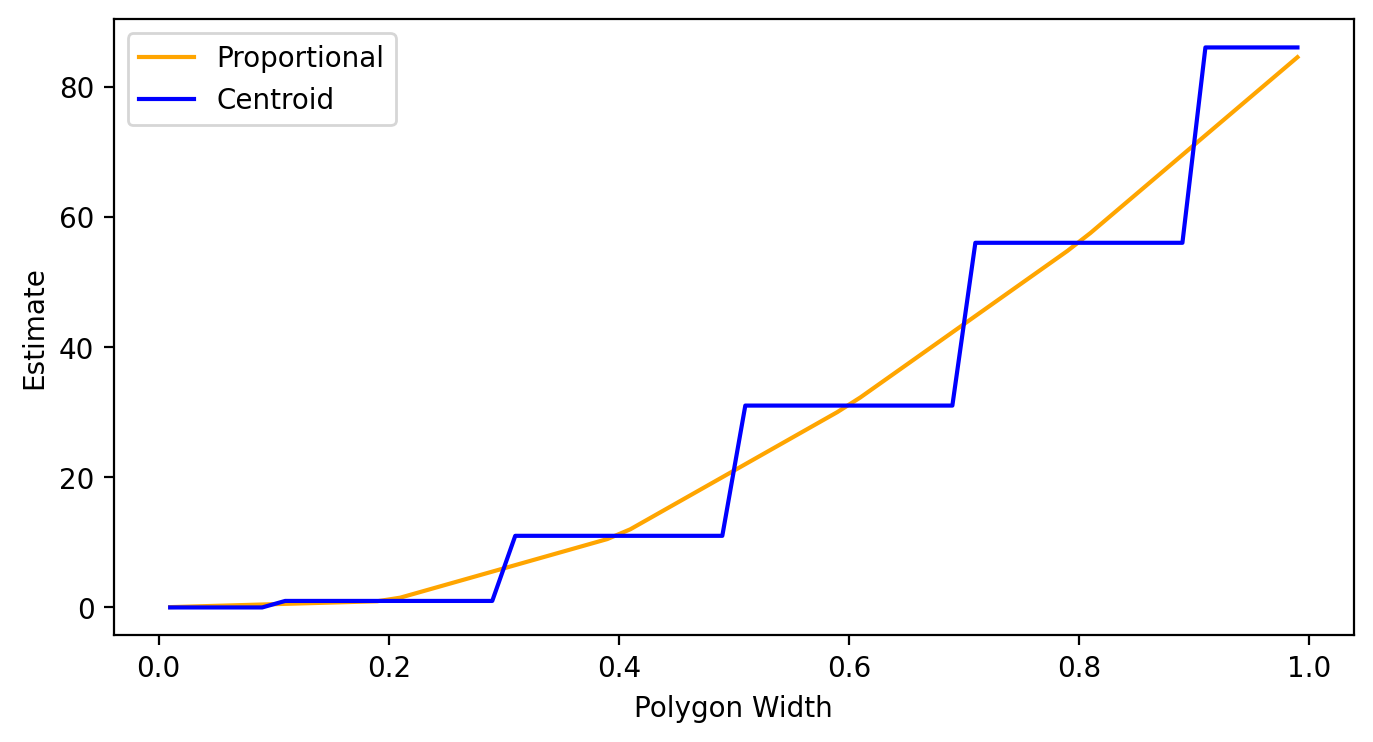

In [4]:
# (OPTIONAL) Run tests for each of the major functions

def test_get_actual_value():
    """
    Test the get_actual_value function.
    """
    data = np.array([0.15, 0.21, 0.29, 0.43, 0.53, 0.67, 0.75, 0.85, 0.95])
    width = 0.3
    result = get_actual_value(data, 0, width)
    assert result == 3, f"Expected 3, but got {result}"
    
def test_proportional_allocation_estimate():
    """
    Test the proportional_allocation_estimate function.
    """
    count1 = np.array([2, 3, 5])
    edges1 = np.array([0.0, 0.2, 0.4, 0.6])
    # polygon_width1 = 0.3
    polygon1 = [0.0, 0.3]
    result1 = proportional_allocation_estimate(count1, edges1, polygon1[0], polygon1[1])
    assert np.isclose(result1, 3.5), f"Expected 3.5, but got {result1}"
    
    count2 = np.array([2, 3, 5])
    edges2 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon2 = [0.0, 0.1]
    result2 = proportional_allocation_estimate(count2, edges2, polygon2[0], polygon2[1])
    assert np.isclose(result2,1), f"Expected 1, but got {result2}"

    count3 = np.array([2, 3, 5])
    edges3 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon3 = [0.0, 0.25]
    result3 = proportional_allocation_estimate(count3, edges3, polygon3[0], polygon3[1])
    truth = 2 + (3 * (0.25 - 0.2) / 0.2)
    assert np.isclose(result3, truth), f"Expected {truth}, but got {result3}"
    
    count4 = np.array([2, 3, 5])
    edges4 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon4 = [0.1, 0.5]
    result4 = proportional_allocation_estimate(count4, edges4, polygon4[0], polygon4[1])
    assert np.isclose(result4, 6.5), f"Expected 6.5, but got {result4}"

def test_centroid_allocation_estimate():
    """
    Test the centroid_allocation_estimate function.
    """
    count1 = np.array([2, 3, 5])
    edges1 = np.array([0.0, 0.2, 0.4, 0.6])
    # polygon_width1 = 0.25
    polygon1 = [0.0, 0.25]
    result1 = centroid_allocation_estimate(count1, edges1, polygon1[0], polygon1[1])
    assert np.isclose(result1,2), f"Expected 2, but got {result1}"
    
    count2 = np.array([2, 3, 5])
    edges2 = np.array([0.0, 0.2, 0.4, 0.6])
    # polygon_width2 = 0.35
    polygon2 = [0.0, 0.35]
    result2 = centroid_allocation_estimate(count2, edges2, polygon2[0], polygon2[1])
    assert np.isclose(result2, 5), f"Expected 5, but got {result2}"
    
    count3 = np.array([2, 3, 5])
    edges3 = np.array([0.0, 0.2, 0.4, 0.6])
    polygon3 = [0.15, 0.45]
    result3 = centroid_allocation_estimate(count3, edges3, polygon3[0], polygon3[1])
    assert np.isclose(result3, 3), f"Expected 3, but got {result3}"

def test_proportional_allocation_estimate2():
    """
    Test the proportional_allocation_estimate function with a different case.
    """
    dp = np.linspace(0.01, 0.99, 50)
    count1 = np.array([1, 10, 20, 25, 30])
    edges1 = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    tot_proportional = []
    tot_centroid = []
    for polygon_width in dp:
        tot_proportional.append(proportional_allocation_estimate(count1, edges1, 0, polygon_width))
        tot_centroid.append(centroid_allocation_estimate(count1, edges1, 0, polygon_width))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(dp, tot_proportional, label="Proportional" , color='orange')
    ax.plot(dp, tot_centroid, label="Centroid" , color='blue')
    ax.set_xlabel('Polygon Width')
    ax.set_ylabel('Estimate')
    ax.legend()
    

test_get_actual_value()
test_proportional_allocation_estimate()
test_centroid_allocation_estimate()
test_proportional_allocation_estimate2()

### Generate samples from each type of point process

In [5]:
# Parameters for Poisson Process
N = 200

# Parameters for Neyman-Scott Process
lambda_p = 10
lambda_c = N / lambda_p
sigma = 0.05

# Parameters for log-Gaussian Cox Process
L = 1             # Length of domain
dx = 0.01          # Bin width
mean_log_intensity = np.log(N)  # Mean of log-intensity
variance = 1     # Variance of the Gaussian Process
length_scale = 0.05 # Length scale of covariance

sample_generator = {}
sample_generator['poisson'] = lambda x, start, end: get_poisson_process_samples(x, start, end)
sample_generator['neyman-scott'] = lambda x, start, end: get_neyman_scott_process(lambda_p, x / lambda_p, sigma, start, end)
sample_generator['lgcp'] = lambda x, start, end: get_log_gaussian_cox_process(dx, np.log(x), variance, length_scale, start, end)

### Run the simulation for one of the point processes assuming the one edge is fixed at $x=0$

In [6]:
from tqdm import tqdm

# Distribution under test:
point_process = 'poisson'

# Run many iterations to get a distribution of the estimates
trials = 500
mean_estimate_centroid = []
var_estimate_centroid = []
mean_estimate_proportional = []
var_estimate_proportional = []
mean_mape_proportional = []
mean_mape_centroid = []
for grid_width, polygon_width in tqdm(zip(dg, dp),  total=len(dg)):
    errors_centroid = []
    errors_proportional = []
    mape_centroid = []
    mape_proportional = []
    
    for _ in range(trials):
        data = sample_generator[point_process](rate, start, end)
        count, edges = create_gridded_data(data, grid_width, start, end)
        actual_value = get_actual_value(data, 0, polygon_width)
        estimate_centroid = centroid_allocation_estimate(count, edges, 0, polygon_width)
        estimate_proportional = proportional_allocation_estimate(count, edges, 0, polygon_width)
        errors_centroid.append(estimate_centroid - actual_value)
        errors_proportional.append(estimate_proportional - actual_value)
        if actual_value != 0:
            mape_centroid.append(np.abs(estimate_centroid - actual_value) / actual_value * 100)
            mape_proportional.append(np.abs(estimate_proportional - actual_value) / actual_value * 100)

    # Calculate mean and variance of the estimates
    mean_estimate_centroid.append(np.mean(errors_centroid))
    var_estimate_centroid.append(np.var(errors_centroid))
    mean_estimate_proportional.append(np.mean(errors_proportional))
    var_estimate_proportional.append(np.var(errors_proportional))
    mean_mape_centroid.append(np.mean(mape_centroid))
    mean_mape_proportional.append(np.mean(mape_proportional))

100%|██████████| 1000/1000 [00:25<00:00, 39.54it/s]


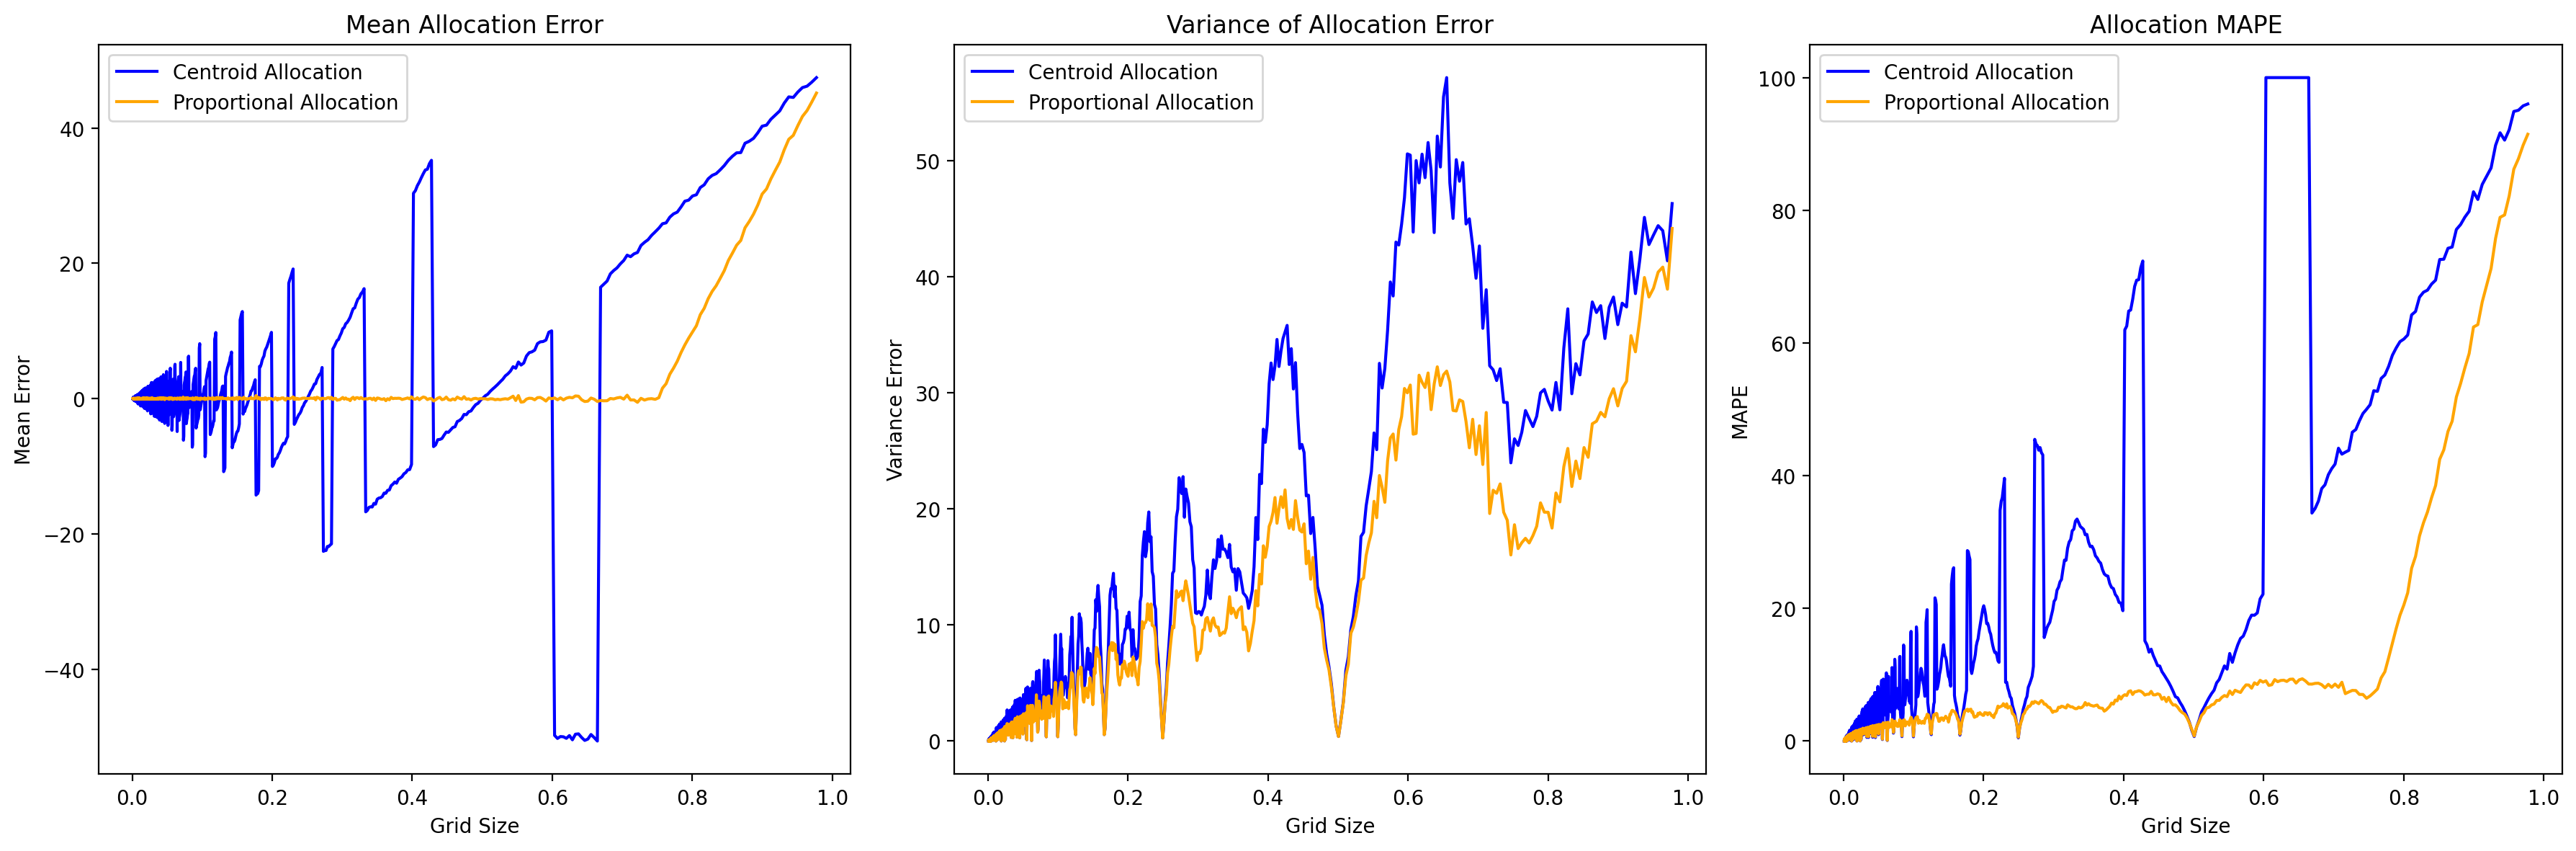

In [7]:
# Plot the resulting mean and variance of the estimates
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(dg, mean_estimate_centroid, label='Centroid Allocation', color='blue')
ax[0].plot(dg, mean_estimate_proportional, label='Proportional Allocation', color='orange')
ax[0].set_title('Mean Allocation Error')
ax[0].set_xlabel('Grid Size')
ax[0].set_ylabel('Mean Error')
ax[0].legend()
ax[1].plot(dg, var_estimate_centroid, label='Centroid Allocation', color='blue')
ax[1].plot(dg, var_estimate_proportional, label='Proportional Allocation', color='orange')
ax[1].set_title('Variance of Allocation Error')
ax[1].set_xlabel('Grid Size')
ax[1].set_ylabel('Variance Error')
ax[1].legend()
ax[2].plot(dg, mean_mape_centroid, label='Centroid Allocation', color='blue')
ax[2].plot(dg, mean_mape_proportional, label='Proportional Allocation', color='orange')
ax[2].set_title('Allocation MAPE')
ax[2].set_xlabel('Grid Size')
ax[2].set_ylabel('MAPE')
ax[2].legend()
plt.tight_layout()
plt.show()

### Run the simulation for one of the point processes randomly setting the edges

In [8]:
from tqdm import tqdm

# Distribution under test:
point_process = 'poisson'

# Run many iterations to get a distribution of the estimates
trials = 500
mean_estimate_centroid = []
var_estimate_centroid = []
mean_estimate_proportional = []
var_estimate_proportional = []
mean_mape_proportional = []
mean_mape_centroid = []
for grid_width, polygon_width in tqdm(zip(dg, dp),  total=len(dg)):
    errors_centroid = []
    errors_proportional = []
    mape_centroid = []
    mape_proportional = []
    
    for _ in range(trials):
        # Generate polygon
        polygon_start = np.random.uniform(low=0.0, high=1.0-grid_width)
        polygon_end = polygon_start + polygon_width
        
        data = sample_generator[point_process](rate, start, end)
        count, edges = create_gridded_data(data, grid_width, start, end)
        actual_value = get_actual_value(data, polygon_start, polygon_end)

        estimate_centroid = centroid_allocation_estimate(count, edges, polygon_start, polygon_end)
        estimate_proportional = proportional_allocation_estimate(count, edges, polygon_start, polygon_end)
        errors_centroid.append(estimate_centroid - actual_value)
        errors_proportional.append(estimate_proportional - actual_value)
        if actual_value != 0:
            mape_centroid.append(np.abs(estimate_centroid - actual_value) / actual_value * 100)
            mape_proportional.append(np.abs(estimate_proportional - actual_value) / actual_value * 100)
        # else:
        #     mape_centroid.append(0)
        #     mape_proportional.append(0)

    # Calculate mean and variance of the estimates
    mean_estimate_centroid.append(np.mean(errors_centroid))
    var_estimate_centroid.append(np.var(errors_centroid))
    mean_estimate_proportional.append(np.mean(errors_proportional))
    var_estimate_proportional.append(np.var(errors_proportional))
    mean_mape_centroid.append(np.mean(mape_centroid))
    mean_mape_proportional.append(np.mean(mape_proportional))


100%|██████████| 1000/1000 [00:25<00:00, 38.52it/s]


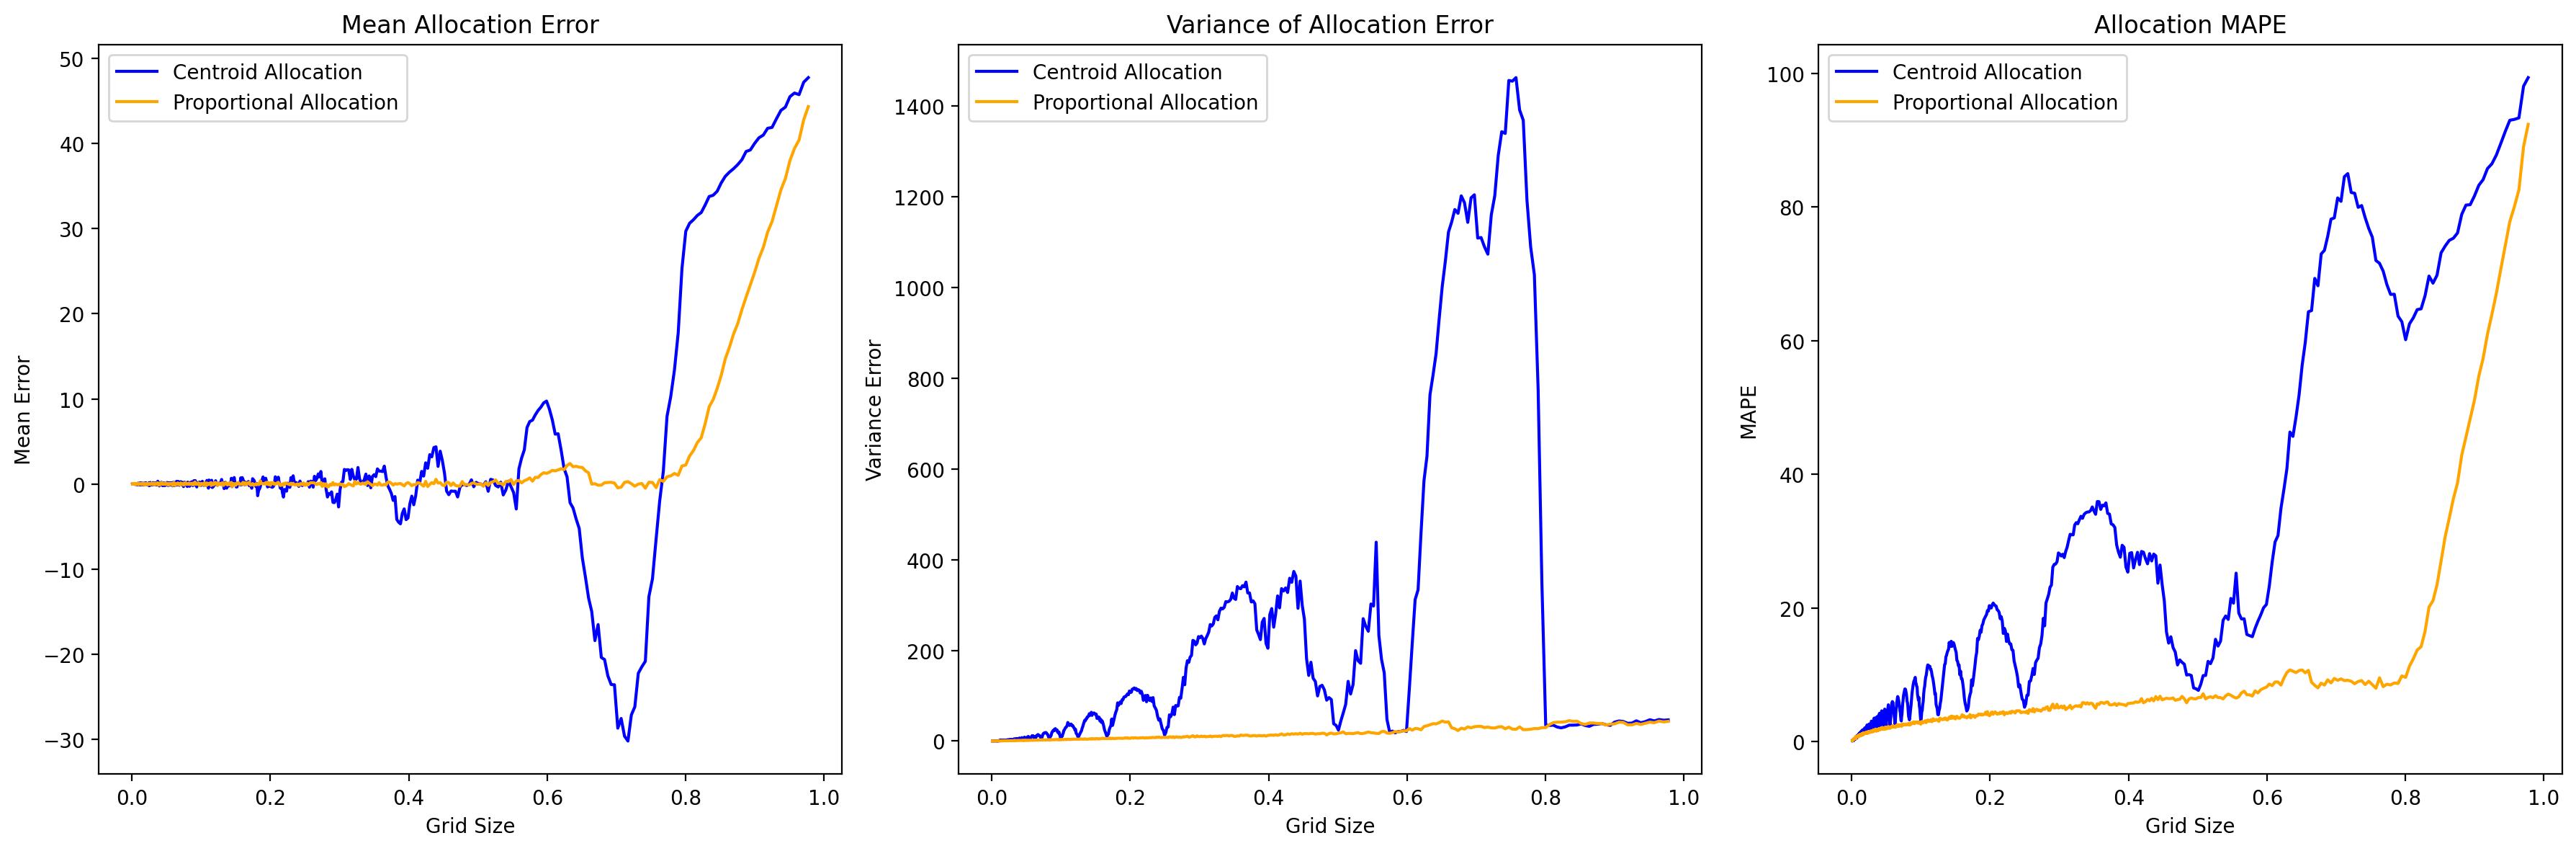

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(dg, mean_estimate_centroid, label='Centroid Allocation', color='blue')
ax[0].plot(dg, mean_estimate_proportional, label='Proportional Allocation', color='orange')
ax[0].set_title('Mean Allocation Error')
ax[0].set_xlabel('Grid Size')
ax[0].set_ylabel('Mean Error')
ax[0].legend()
ax[1].plot(dg, var_estimate_centroid, label='Centroid Allocation', color='blue')
ax[1].plot(dg, var_estimate_proportional, label='Proportional Allocation', color='orange')
ax[1].set_title('Variance of Allocation Error')
ax[1].set_xlabel('Grid Size')
ax[1].set_ylabel('Variance Error')
ax[1].legend()
ax[2].plot(dg, mean_mape_centroid, label='Centroid Allocation', color='blue')
ax[2].plot(dg, mean_mape_proportional, label='Proportional Allocation', color='orange')
ax[2].set_title('Allocation MAPE')
ax[2].set_xlabel('Grid Size')
ax[2].set_ylabel('MAPE')
ax[2].legend()
plt.tight_layout()
plt.show()

## Next, add some random noise to the polygon size

In [10]:
from tqdm import tqdm

# Distribution under test:
point_process = 'poisson'

# Run many iterations to get a distribution of the estimates
trials = 500
mean_estimate_centroid = []
var_estimate_centroid = []
mean_estimate_proportional = []
var_estimate_proportional = []
mean_mape_proportional = []
mean_mape_centroid = []
for grid_width, polygon_width in tqdm(zip(dg, dp),  total=len(dg)):
    errors_centroid = []
    errors_proportional = []
    mape_centroid = []
    mape_proportional = []
    
    for _ in range(trials):
        # Generate polygon
        polygon_start = np.random.uniform(low=0.0, high=1.0-grid_width)
        polygon_end = polygon_start + polygon_width
        
        data = sample_generator[point_process](rate, start, end)
        count, edges = create_gridded_data(data, grid_width, start, end)
        actual_value = get_actual_value(data, polygon_start, polygon_end)

        estimate_centroid = centroid_allocation_estimate(count, edges, polygon_start, polygon_end)
        estimate_proportional = proportional_allocation_estimate(count, edges, polygon_start, polygon_end)
        errors_centroid.append(estimate_centroid - actual_value)
        errors_proportional.append(estimate_proportional - actual_value)
        if actual_value != 0:
            mape_centroid.append(np.abs(estimate_centroid - actual_value) / actual_value * 100)
            mape_proportional.append(np.abs(estimate_proportional - actual_value) / actual_value * 100)
        # else:
        #     mape_centroid.append(0)
        #     mape_proportional.append(0)

    # Calculate mean and variance of the estimates
    mean_estimate_centroid.append(np.mean(errors_centroid))
    var_estimate_centroid.append(np.var(errors_centroid))
    mean_estimate_proportional.append(np.mean(errors_proportional))
    var_estimate_proportional.append(np.var(errors_proportional))
    mean_mape_centroid.append(np.mean(mape_centroid))
    mean_mape_proportional.append(np.mean(mape_proportional))

100%|██████████| 1000/1000 [00:25<00:00, 38.48it/s]
